In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 


from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for images, labels in test_loader:
    print(f'Batch size: {images.size(0)}') 
    break 


Batch size: 64


In [3]:
device = 'mps'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
tf = transforms.Compose([transforms.ToTensor(),
 transforms.Normalize((0.1307,), (0.3081,))])

In [6]:
#3
train_loader = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=True, transform=tf),
batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=False, transform=tf),
batch_size=64, shuffle=True)

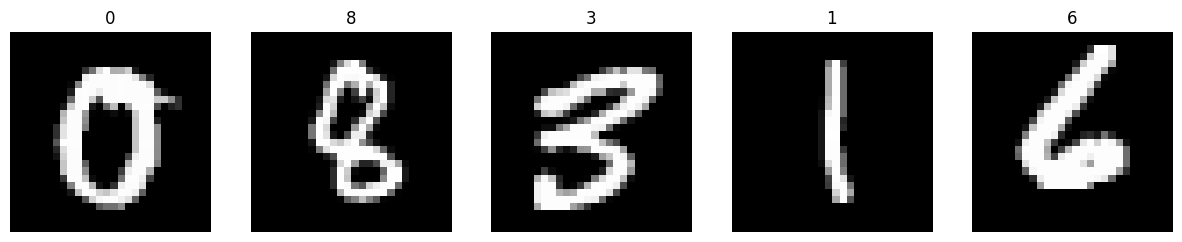

In [27]:

# Début du code
batch = next(iter(train_loader))
x = batch[0][:5]
y = batch[1][:5]

# Configuration pour les images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Boucle pour afficher chaque image
for i in range(5):
    image = x[i].numpy().squeeze()  
    label = y[i].item()

    axes[i].imshow(image, cmap='gray') 
    axes[i].set_title(f'{label}')
    axes[i].axis('off')

plt.show()


In [35]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super(ConvNet, self).__init__()
        
        # Définition de l'architecture du réseau
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(in_features=n_kernels * 4 * 4, out_features=50),
            nn.ReLU(),

            nn.Linear(in_features=50, out_features=output_size)
        )

    def forward(self, x):
        return self.net(x)

# Supposons que le modèle ConvNet est déjà entraîné et prêt à être sauvegardé
model = ConvNet(input_size=28*28, n_kernels=6, output_size=10)
model.to(device)

# Sauvegarder le modèle ConvNet
model_path = "convnet_model.pt"
torch.save(model.state_dict(), model_path)
print(f"Modèle ConvNet sauvegardé sous {model_path}")

# Charger le modèle ConvNet à partir du fichier sauvegardé
loaded_model = ConvNet(input_size=28*28, n_kernels=6, output_size=10)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)

# Vérifier que les paramètres sont identiques
original_params = model.state_dict()
loaded_params = loaded_model.state_dict()

for key in original_params:
    if not torch.equal(original_params[key], loaded_params[key]):
        print(f"Paramètre {key} différent entre le modèle original et le modèle chargé")
print("Modèle chargé correctement avec les mêmes paramètres que le modèle original")


Modèle ConvNet sauvegardé sous convnet_model.pt
Modèle chargé correctement avec les mêmes paramètres que le modèle original


In [36]:
def train(model, train_loader, device, n_epoch=1, perm=torch.arange(0, 784).long()):
    # Code de la fonction train
    model.train()
    optimizer = torch.optim.AdamW(model.parameters())
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            optimizer.zero_grad()
            logits = model(data)
            loss = F.cross_entropy(logits, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch={epoch}, Step={i+1}: Loss={running_loss / 100:.4f}')
                running_loss = 0.0


In [37]:
def test(model, test_loader, device, perm=torch.arange(0, 784).long()):
    model.eval()  # Mettre le modèle en mode évaluation
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Désactiver la rétropropagation pour l'évaluation
        for data, target in tqdm(test_loader):  # Boucler sur le test loader avec une barre de progression
            data, target = data.to(device), target.to(device)  # Envoyer les données à l'appareil

            # Appliquer les permutations de pixels par la matrice circulaire de Toeplitz
            data = data.view(-1, 28*28)  # Aplatir les données
            data = data[:, perm]  # Appliquer la permutation
            data = data.view(-1, 1, 28, 28)  # Restructurer les données en format 1x28x28

            logits = model(data)  # Propagation avant pour obtenir les prédictions
            test_loss += F.cross_entropy(logits, target, reduction='sum').item()  # Calculer le loss total
            pred = logits.argmax(dim=1)  # Obtenir la prédiction avec la probabilité la plus élevée
            correct += pred.eq(target).sum().item()  # Compter les prédictions correctes
            total += target.size(0)  # Total des échantillons évalués

    test_loss /= total  # Calculer la perte moyenne
    accuracy = correct / total  # Calculer l'accuracy

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
    return test_loss, accuracy  # Retourner les résultats de test


In [11]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernel, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernel, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=n_kernel, out_channels=n_kernel, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=n_kernel * 4 * 4, out_features=50),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.net(x)

In [12]:
train(model, train_loader, device, n_epoch=1)

 12%|█▏        | 112/938 [00:01<00:10, 78.32it/s]

Epoch=0, Step=100: Loss=1.1042


 22%|██▏       | 210/938 [00:02<00:09, 77.83it/s]

Epoch=0, Step=200: Loss=0.3618


 34%|███▎      | 316/938 [00:04<00:07, 80.38it/s]

Epoch=0, Step=300: Loss=0.2630


 43%|████▎     | 407/938 [00:05<00:06, 77.47it/s]

Epoch=0, Step=400: Loss=0.2281


 54%|█████▍    | 510/938 [00:06<00:05, 80.01it/s]

Epoch=0, Step=500: Loss=0.1774


 65%|██████▍   | 607/938 [00:07<00:04, 81.57it/s]

Epoch=0, Step=600: Loss=0.1640


 76%|███████▌  | 712/938 [00:09<00:02, 77.16it/s]

Epoch=0, Step=700: Loss=0.1497


 87%|████████▋ | 813/938 [00:10<00:01, 81.24it/s]

Epoch=0, Step=800: Loss=0.1317


 97%|█████████▋| 912/938 [00:11<00:00, 79.32it/s]

Epoch=0, Step=900: Loss=0.1293


100%|██████████| 938/938 [00:11<00:00, 78.76it/s]


In [13]:
test(model, train_loader, device)

100%|██████████| 938/938 [00:09<00:00, 97.61it/s] 

Test Loss: 0.1185, Accuracy: 0.9636


(0.1185329927722613, 0.9636333333333333)

In [14]:
n_kernels = 6
convnet = ConvNet(input_size, n_kernels, output_size)
convnet.to(device)
print(f"Parameters={sum(p.numel() for p in convnet.parameters())/1e3}K")
train(convnet, train_loader, device, n_epoch=1)
test(convnet, train_loader, device)

Parameters=6.422K


 12%|█▏        | 114/938 [00:01<00:10, 77.68it/s]

Epoch=0, Step=100: Loss=1.1515


 23%|██▎       | 213/938 [00:02<00:09, 79.53it/s]

Epoch=0, Step=200: Loss=0.3880


 33%|███▎      | 313/938 [00:03<00:08, 74.53it/s]

Epoch=0, Step=300: Loss=0.2878


 43%|████▎     | 406/938 [00:05<00:06, 78.92it/s]

Epoch=0, Step=400: Loss=0.2585


 55%|█████▍    | 514/938 [00:06<00:05, 77.17it/s]

Epoch=0, Step=500: Loss=0.2030


 65%|██████▌   | 614/938 [00:07<00:04, 77.83it/s]

Epoch=0, Step=600: Loss=0.1744


 76%|███████▌  | 709/938 [00:09<00:02, 78.18it/s]

Epoch=0, Step=700: Loss=0.1544


 86%|████████▌ | 809/938 [00:10<00:01, 80.15it/s]

Epoch=0, Step=800: Loss=0.1511


 98%|█████████▊| 917/938 [00:11<00:00, 76.72it/s]

Epoch=0, Step=900: Loss=0.1317


100%|██████████| 938/938 [00:09<00:00, 98.32it/s] 

Test Loss: 0.1185, Accuracy: 0.9636


(0.11853361948033174, 0.9635666666666667)

In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size) 
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.layers(x)

input_size = 28 * 28  
output_size = 10 
n_hidden = 8 

mlp = MLP(input_size, n_hidden, output_size)
mlp.to(device)

print(f"Parameters={sum(p.numel() for p in mlp.parameters())/1e3}K")

Parameters=6.442K


In [16]:
train(mlp, train_loader, device, n_epoch=1)

 12%|█▏        | 114/938 [00:01<00:08, 94.55it/s]

Epoch=0, Step=100: Loss=1.9148


 23%|██▎       | 217/938 [00:02<00:07, 98.53it/s]

Epoch=0, Step=200: Loss=1.2071


 33%|███▎      | 313/938 [00:03<00:06, 97.42it/s] 

Epoch=0, Step=300: Loss=0.8155


 45%|████▍     | 419/938 [00:04<00:05, 96.75it/s] 

Epoch=0, Step=400: Loss=0.6316


 55%|█████▍    | 513/938 [00:05<00:04, 96.89it/s] 

Epoch=0, Step=500: Loss=0.5465


 66%|██████▌   | 618/938 [00:06<00:03, 97.14it/s] 

Epoch=0, Step=600: Loss=0.5010


 76%|███████▌  | 711/938 [00:07<00:02, 94.86it/s]

Epoch=0, Step=700: Loss=0.4308


 87%|████████▋ | 813/938 [00:08<00:01, 96.90it/s]

Epoch=0, Step=800: Loss=0.4568


 98%|█████████▊| 918/938 [00:09<00:00, 100.18it/s]

Epoch=0, Step=900: Loss=0.4346


100%|██████████| 938/938 [00:09<00:00, 97.29it/s] 


In [17]:
test(mlp, train_loader, device)

100%|██████████| 938/938 [00:08<00:00, 109.70it/s]

Test Loss: 0.4029, Accuracy: 0.8896


(0.40286368956565854, 0.8896333333333334)

In [18]:
cnn_parameters = sum(p.numel() for p in model.parameters())
mlp_parameters = sum(p.numel() for p in mlp.parameters())
print(f"Nombre de paramètres CNN: {cnn_parameters}")
print(f"Nombre de paramètres MLP: {mlp_parameters}")


Nombre de paramètres CNN: 6422
Nombre de paramètres MLP: 6442


In [25]:
import time

# Entraîner le CNN sans permutation
start_time = time.time()
cnn_loss_history = train(model, train_loader, device, n_epoch=1)
cnn_training_time = time.time() - start_time

# Entraîner le MLP sans permutation
start_time = time.time()
mlp_loss_history = train(mlp, train_loader, device, n_epoch=1)
mlp_training_time = time.time() - start_time

# Évaluer les deux modèles sans permutation
cnn_test_loss, cnn_test_accuracy = test(model, test_loader, device)
mlp_test_loss, mlp_test_accuracy = test(mlp, test_loader, device)

print(f"______________________")

print(f"Temps d'entraînement CNN: {cnn_training_time:.2f} secondes")
print(f"Temps d'entraînement MLP: {mlp_training_time:.2f} secondes")

print(f"----------------------")

print(f"Loss du CNN sur le jeu de test: {cnn_test_loss:.4f}")
print(f"Accuracy du CNN sur le jeu de test: {cnn_test_accuracy:.4f}")

print(f"----------------------")

print(f"Loss du MLP sur le jeu de test: {mlp_test_loss:.4f}")
print(f"Accuracy du MLP sur le jeu de test: {mlp_test_accuracy:.4f}")

print(f"______________________")


 12%|█▏        | 114/938 [00:01<00:11, 73.06it/s]

Epoch=0, Step=100: Loss=1.8986


 22%|██▏       | 211/938 [00:02<00:09, 73.80it/s]

Epoch=0, Step=200: Loss=0.4911


 33%|███▎      | 313/938 [00:04<00:07, 81.07it/s]

Epoch=0, Step=300: Loss=0.3051


 44%|████▍     | 411/938 [00:05<00:06, 79.55it/s]

Epoch=0, Step=400: Loss=0.2474


 54%|█████▍    | 508/938 [00:06<00:05, 73.92it/s]

Epoch=0, Step=500: Loss=0.2156


 65%|██████▌   | 613/938 [00:08<00:04, 73.20it/s]

Epoch=0, Step=600: Loss=0.1847


 76%|███████▌  | 711/938 [00:09<00:02, 76.77it/s]

Epoch=0, Step=700: Loss=0.1798


 86%|████████▌ | 808/938 [00:10<00:01, 69.43it/s]

Epoch=0, Step=800: Loss=0.1422


 98%|█████████▊| 915/938 [00:12<00:00, 77.32it/s]

Epoch=0, Step=900: Loss=0.1394


 13%|█▎        | 118/938 [00:01<00:08, 99.21it/s]

Epoch=0, Step=100: Loss=0.5806


 22%|██▏       | 211/938 [00:02<00:07, 94.63it/s] 

Epoch=0, Step=200: Loss=0.4069


 33%|███▎      | 314/938 [00:03<00:06, 99.06it/s]

Epoch=0, Step=300: Loss=0.3746


 44%|████▍     | 414/938 [00:04<00:05, 99.97it/s] 

Epoch=0, Step=400: Loss=0.3639


 54%|█████▍    | 508/938 [00:05<00:04, 95.17it/s] 

Epoch=0, Step=500: Loss=0.3486


 66%|██████▌   | 616/938 [00:06<00:03, 99.69it/s] 

Epoch=0, Step=600: Loss=0.3646


 75%|███████▌  | 708/938 [00:07<00:02, 95.04it/s]

Epoch=0, Step=700: Loss=0.3372


 87%|████████▋ | 816/938 [00:08<00:01, 98.16it/s] 

Epoch=0, Step=800: Loss=0.3360


 97%|█████████▋| 909/938 [00:09<00:00, 98.02it/s] 

Epoch=0, Step=900: Loss=0.3255


100%|██████████| 157/157 [00:01<00:00, 105.83it/s]


Test Loss: 0.1163, Accuracy: 0.9639


100%|██████████| 157/157 [00:01<00:00, 121.76it/s]

Test Loss: 0.3075, Accuracy: 0.9086
______________________
Temps d'entraînement CNN: 12.37 secondes
Temps d'entraînement MLP: 9.55 secondes
----------------------
Loss du CNN sur le jeu de test: 0.1163
Accuracy du CNN sur le jeu de test: 0.9639
----------------------
Loss du MLP sur le jeu de test: 0.3075
Accuracy du MLP sur le jeu de test: 0.9086
______________________


In [26]:
# Appliquer une permutation aléatoire des indices
perm = torch.randperm(784)

# Réentraîner le CNN avec permutation aléatoire
start_time = time.time()
cnn_loss_history_shuffled = train(model, train_loader, device, n_epoch=1, perm=perm)
cnn_training_time_shuffled = time.time() - start_time

# Réentraîner le MLP avec permutation aléatoire
start_time = time.time()
mlp_loss_history_shuffled = train(mlp, train_loader, device, n_epoch=1, perm=perm)
mlp_training_time_shuffled = time.time() - start_time

# Évaluer les deux modèles avec permutation
cnn_test_loss_shuffled, cnn_test_accuracy_shuffled = test(model, test_loader, device, perm=perm)
mlp_test_loss_shuffled, mlp_test_accuracy_shuffled = test(mlp, test_loader, device, perm=perm)

print(f"______________________")

print(f"Temps d'entraînement CNN (shuffle): {cnn_training_time_shuffled:.2f} secondes")
print(f"Temps d'entraînement MLP (shuffle): {mlp_training_time_shuffled:.2f} secondes")

print(f"----------------------")

print(f"Loss du CNN sur le jeu de test (shuffle): {cnn_test_loss_shuffled:.4f}")
print(f"Accuracy du CNN sur le jeu de test (shuffle): {cnn_test_accuracy_shuffled:.4f}")

print(f"----------------------")

print(f"Loss du MLP sur le jeu de test (shuffle): {mlp_test_loss_shuffled:.4f}")
print(f"Accuracy du MLP sur le jeu de test (shuffle): {mlp_test_accuracy_shuffled:.4f}")

print(f"______________________")


 12%|█▏        | 114/938 [00:01<00:10, 77.96it/s]

Epoch=0, Step=100: Loss=2.0676


 23%|██▎       | 213/938 [00:02<00:09, 76.50it/s]

Epoch=0, Step=200: Loss=1.0880


 33%|███▎      | 310/938 [00:04<00:08, 76.17it/s]

Epoch=0, Step=300: Loss=0.7501


 44%|████▍     | 412/938 [00:05<00:06, 77.75it/s]

Epoch=0, Step=400: Loss=0.6399


 54%|█████▍    | 506/938 [00:06<00:06, 65.12it/s]

Epoch=0, Step=500: Loss=0.5733


 65%|██████▍   | 607/938 [00:08<00:04, 72.88it/s]

Epoch=0, Step=600: Loss=0.5116


 76%|███████▌  | 711/938 [00:09<00:03, 69.30it/s]

Epoch=0, Step=700: Loss=0.4763


 86%|████████▌ | 807/938 [00:11<00:01, 73.77it/s]

Epoch=0, Step=800: Loss=0.4771


 97%|█████████▋| 909/938 [00:12<00:00, 67.58it/s]

Epoch=0, Step=900: Loss=0.4749


 12%|█▏        | 112/938 [00:01<00:08, 97.42it/s]

Epoch=0, Step=100: Loss=1.6402


 23%|██▎       | 218/938 [00:02<00:07, 100.31it/s]

Epoch=0, Step=200: Loss=0.7314


 33%|███▎      | 313/938 [00:03<00:06, 101.69it/s]

Epoch=0, Step=300: Loss=0.5435


 44%|████▍     | 416/938 [00:04<00:05, 96.14it/s] 

Epoch=0, Step=400: Loss=0.4513


 54%|█████▍    | 509/938 [00:05<00:04, 97.52it/s]

Epoch=0, Step=500: Loss=0.4275


 65%|██████▌   | 612/938 [00:06<00:03, 97.82it/s]

Epoch=0, Step=600: Loss=0.3948


 77%|███████▋  | 718/938 [00:07<00:02, 95.03it/s] 

Epoch=0, Step=700: Loss=0.3893


 86%|████████▌ | 809/938 [00:08<00:01, 93.02it/s]

Epoch=0, Step=800: Loss=0.3700


 97%|█████████▋| 914/938 [00:09<00:00, 97.02it/s] 

Epoch=0, Step=900: Loss=0.3477


100%|██████████| 157/157 [00:01<00:00, 103.27it/s]


Test Loss: 0.4035, Accuracy: 0.8714


100%|██████████| 157/157 [00:01<00:00, 119.88it/s]

Test Loss: 0.3296, Accuracy: 0.8985
______________________
Temps d'entraînement CNN (shuffle): 12.95 secondes
Temps d'entraînement MLP (shuffle): 9.74 secondes
----------------------
Loss du CNN sur le jeu de test (shuffle): 0.4035
Accuracy du CNN sur le jeu de test (shuffle): 0.8714
----------------------
Loss du MLP sur le jeu de test (shuffle): 0.3296
Accuracy du MLP sur le jeu de test (shuffle): 0.8985
______________________


Les résultats montrent que les CNNs sont plus performants que les MLPs pour les tâches de vision par ordinateur sur des données structurées. Cependant, leur performance peut être gravement affectée par des perturbations des structures spatiales, alors que les MLPs montrent une robustesse relative mais une performance globale inférieure.

In [39]:
model_path = "convnet_model.pt"
torch.save(model.state_dict(), model_path)
print(f"Modèle ConvNet sauvegardé sous {model_path}")


Modèle ConvNet sauvegardé sous convnet_model.pt


In [40]:
loaded_model = ConvNet(input_size=28*28, n_kernels=6, output_size=10)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)

original_params = model.state_dict()
loaded_params = loaded_model.state_dict()

for key in original_params:
    if not torch.equal(original_params[key], loaded_params[key]):
        print(f"Paramètre {key} différent entre le modèle original et le modèle chargé")
print("Modèle chargé correctement avec les mêmes paramètres que le modèle original")


Modèle chargé correctement avec les mêmes paramètres que le modèle original
